In [2]:
import os
import json

fpth_secret = os.path.join(os.environ['HOME'], 'working/jupyter/secret.json')
with open(fpth_secret) as f:
    secret = json.load(f)
TOKEN = secret['tellus']
HEADERS = {
    'Authorization': 'Bearer ' + TOKEN
}

In [3]:
from utils import *

In [4]:
import json
from pathlib import Path

fpth_data = Path.cwd() / 'N03-22_13_220101.geojson'
with open(fpth_data) as f:
    json_data = json.load(f)

setagaya_features = [f for f in json_data['features'] if f['properties']['N03_007'] == '13112']
print(len(setagaya_features[0]['geometry']['coordinates'][0]))
print(setagaya_features[0]['geometry']['coordinates'][0][0])

In [6]:
tile = {
    'x': 3636,
    'y': 1612,
    'z': 12
}
size = {
    'x': 1,
    'y': 1
}

bbox = calc_tile_bbox(tile, size)
print(bbox)

(139.5703125, 35.67514743608467, 139.658203125, 35.7465122599185)


In [7]:
import requests

def fetch_landsat8_scenes(lat_lon):
    url = 'https://gisapi.tellusxdp.com'
    url += '/api/v1/landsat8/scene'
    
    r = requests.get(url, params=lat_lon, headers=HEADERS)
    return r.json()

lon_lat = {
    'min_lon': 140.502,
    'min_lat': 40.49,
    'max_lon': 140.797,
    'max_lat': 40.744,
}
scenes = fetch_landsat8_scenes(lon_lat)

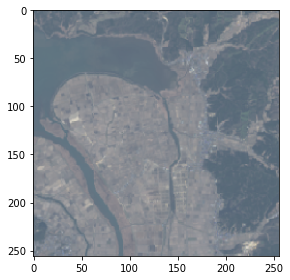

In [8]:
from skimage import io
from io import BytesIO

def fetch_landsat8_image(sceneid, tile, color):
    url = 'https://gisapi.tellusxdp.com'
    url += '/blend/' + sceneid['tile_path'].format(**tile)
    
    r = requests.get(url, headers=HEADERS, params=color)
    return io.imread(BytesIO(r.content))

scene = scenes[0]
color = {
    'preset': 'true'
}
tile = {
    'x': 3645,
    'y': 1535,
    'z': 12
}
img = fetch_landsat8_image(scene, tile, color)
io.imshow(img)

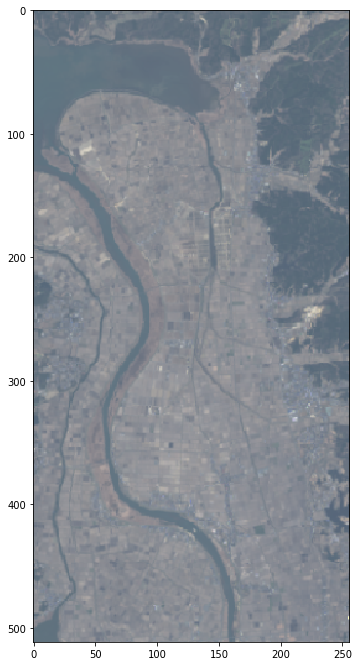

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def fetch_landsat8_images(sceneid, tile, tile_size, color):
    col_img = []
    for x in range(tile_size['x']):
        img = []
        for y in range(tile_size['y']):
            tile_temp = tile.copy()
            tile_temp['x'] += x
            tile_temp['y'] += y
            img.append(fetch_landsat8_image(sceneid, tile_temp, color))
        col_img.append(np.vstack(img))
    return np.hstack(col_img)

tile_size = {
    'x': 1,
    'y': 2
}
img = fetch_landsat8_images(scene, tile, tile_size, color)
plt.figure(figsize=(5, 10))
io.imshow(img)

In [10]:
file_name = 'N03-22_02_220101.geojson'
with open(file_name) as f:
    data = json.load(f)

nakadomari_features = []
for d in data['features']:
    if d['properties']['N03_004'] == '中泊町':
        nakadomari_features.append(d)

print(len(nakadomari_features))

168


/home/ubuntu/working/venv/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


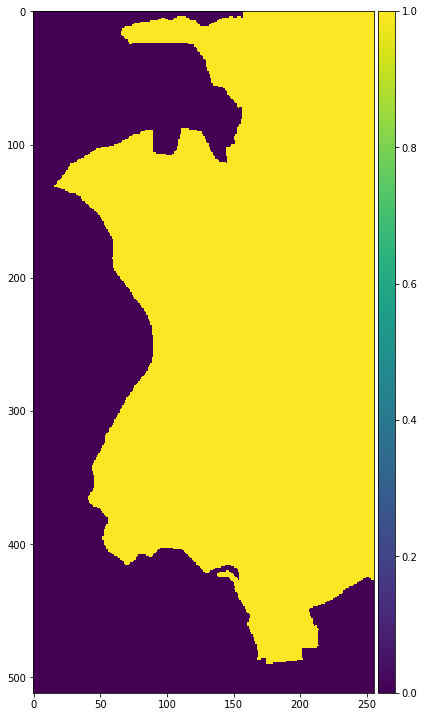

In [11]:
bbox = calc_tile_bbox(tile, tile_size)
img_size = {'height': img.shape[0], 'width': img.shape[1]}
mask = generate_mask_image(nakadomari_features, bbox, img_size)

plt.figure(figsize=(6, 12))
io.imshow(mask)

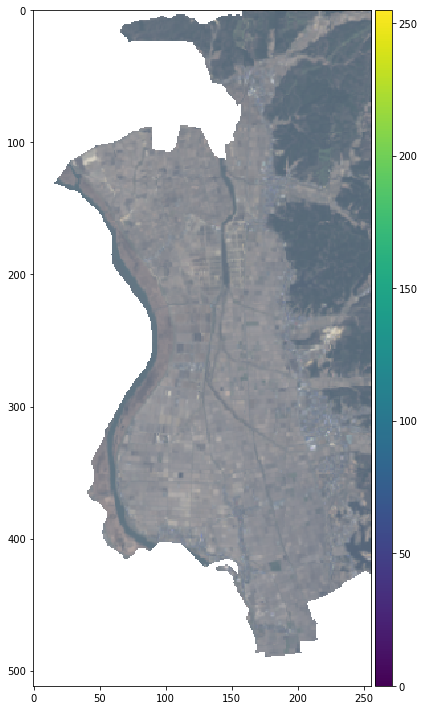

In [12]:
filtered_img = filter_mask(img, mask)

plt.figure(figsize=(6, 12))
io.imshow(filtered_img)